In [1]:
import torch
import numpy as np
import math
import os
import pytorch_lightning as pl
import torch
from hydra.utils import instantiate

In [2]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "4"

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

environ["BLISS_HOME"] = str("/home/songju/bliss")

In [3]:
os.environ["BLISS_HOME"]

'/home/songju/bliss'

In [4]:
os.getcwd()

'/home/songju/bliss/case_studies/redshift_estimation/notebooks'

I have stored the two checkpoints in the following locations:
   1.  `/data/scratch/declan/sdss_encoder_ckpt.ckpt` for the SDSS-like galaxies
   2.  `/data/scratch/declan/dc2_encoder_ckpt.ckpt` for the DC2-like galaxies

Recall that the corresponding directories containing the data used to train these two encoder are in
   1. `/data/scratch/declan/sdss_like_galaxies` for the SDSS-like galaxies
   2. `/data/scratch/declan/dc2_like_galaxies` for the DC2-like galaxies

Below, I will load the DC2 checkpoint for example. You should change both fields below to the corresponding ones for SDSS-like data. Note I give a checkpoint path and the location of the training data.

In [5]:
with initialize(config_path="../", version_base=None):
    cfg = compose("redshift", {
        "predict.weight_save_path=/data/scratch/declan/dc2_encoder_ckpt.ckpt",
        "cached_simulator.cached_data_path=/data/scratch/declan/dc2_like_galaxies"
        })

This cell will take a while because it loads all of the training data (100 GB)

In [6]:
pl.seed_everything(cfg.train.seed)

# setup dataset and encoder
dataset = instantiate(cfg.train.data_source)
encoder = instantiate(cfg.train.encoder)

Global seed set to 42


We aren't technically in `predict` mode so we need to manually load the checkpoint to the encoder.

In [7]:
PATH = "/data/scratch/declan/dc2_encoder_ckpt.ckpt"
checkpoint = torch.load(PATH)
encoder.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Your tasks are as follows:
- From the dataset, plot representative example images (you only need a few, like 2-3. You can pick the best ones to include in the write-up).
- Feed these images through the encoder to get predictions for all quantities. Plot predictions of location (e.g. with an "x" market) overlaid on the top of the example images. If stuff is working well, these should be right in the center of the galaxies approximately. Can you think of any clever ways to visualize redshift predictions for one example image?
- Create a scatterplot of predicted redshift vs. true redshift for all data in the training set. You can do an out-of-sample plot for validation data as well.
- Compute metrics such as MSE and NLL averaged across the training dataset. You can also do an out-of-sample plot for validation data as well.


Below, I work with an example observation just to provide a quick example.

In [8]:
train_dataloader = dataset.train_dataloader() # the data we trained on

In [9]:
val_dataloader = dataset.val_dataloader() # didn't train on, but used to choose checkpoint I think

You will have to iterate through the whole dataloader of training and/or validation data.

In [10]:
observation = next(iter(train_dataloader))

In [11]:
observation.keys()

dict_keys(['images', 'background', 'deconvolution', 'psf_params', 'tile_catalog'])

In [12]:
observation['images'].shape

torch.Size([32, 5, 80, 80])

Recall the tile catalog contains the "true" values used to generate the images. 

In [13]:
observation['tile_catalog'].keys()

dict_keys(['locs', 'n_sources', 'source_type', 'galaxy_fluxes', 'galaxy_params', 'star_fluxes', 'redshifts'])

Let's use the untrained encoder for prediction (it should perform very badly). 

In [14]:
est_cat_ori = encoder.sample(observation, use_mode=True) # I'm using the mode to predict

The estimated catalog `est_cat` now contains the predicted values for each quantity. We can compre to the ground truth above.

In [15]:
est_cat = est_cat_ori.to_dict()
est_cat.keys()

dict_keys(['locs', 'n_sources', 'star_fluxes', 'source_type', 'galaxy_params', 'galaxy_fluxes', 'redshifts'])

When `observation` is passed to `encoder`, the encoder ignores the ground truth `observation['tile_catalog']` to make the prediction obviously. But now we can compare the prediction to the ground truth.

In [16]:
est_redshifts = torch.round(est_cat['redshifts'][0].reshape(18,18), decimals=2) # for one image

In [17]:
observation['tile_catalog']['redshifts'][0].shape

torch.Size([20, 20, 1, 1])

The shapes are off, as we see that our estimated catalog is 18x18. This is because when training on the true images, the edge is filtered out. We can ignore it as well. 

In [18]:
true_redshifts = observation['tile_catalog']['redshifts'][0][1:-1, 1:-1].reshape((18,18))

In [19]:
true_redshifts.shape

torch.Size([18, 18])

At a glance, looks pretty poor. I suspect SDSS is better and something simply went wrong with DC2 (we'll investigate).

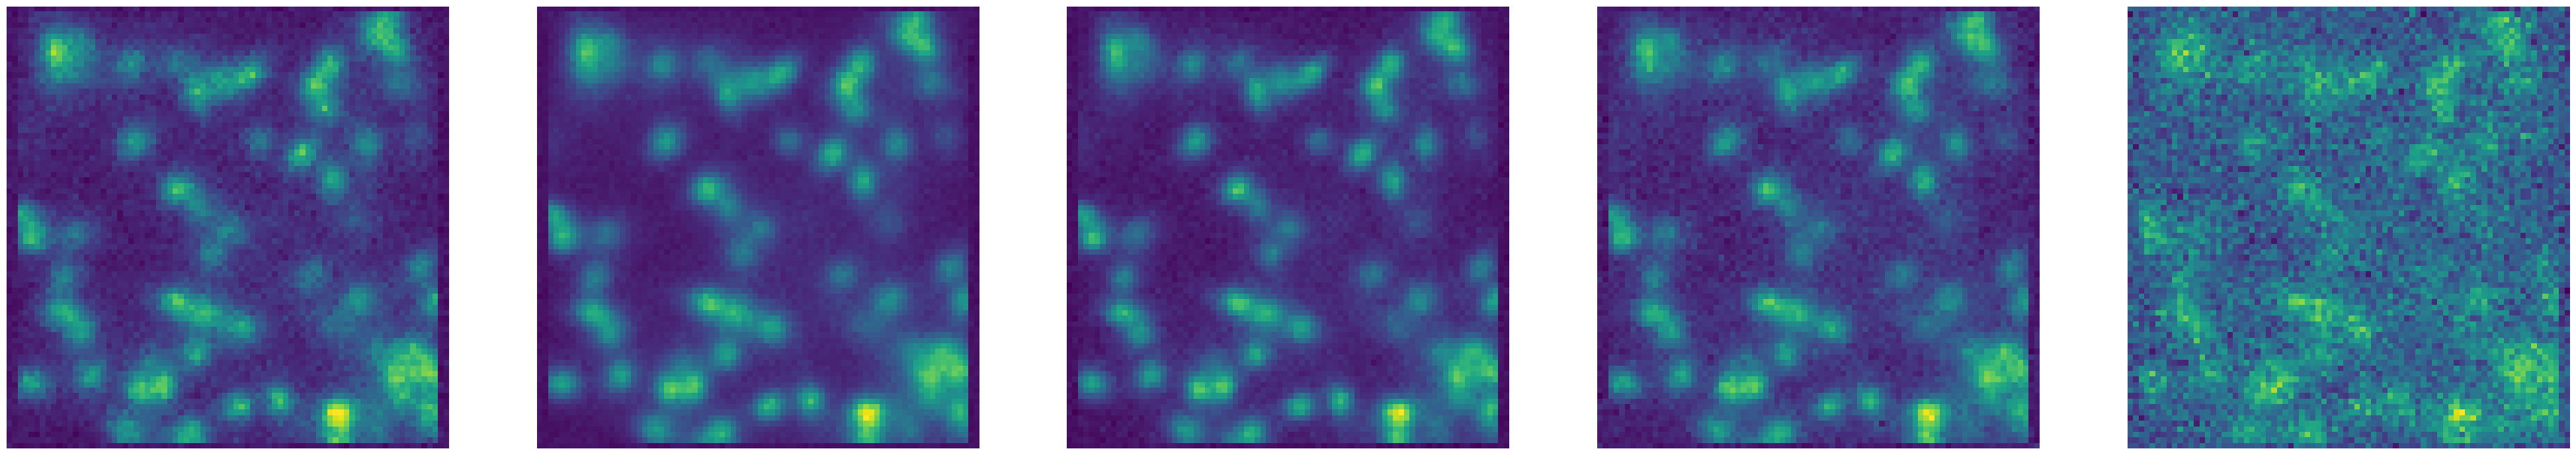

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 50))  # Adjust the figure size as needed

# Display each image in a subplot
for i in range(5):
    plt.subplot(1, 5, i+1)  # 1 row, 5 columns, ith subplot
    plt.imshow(observation['images'][0][i])
    plt.axis('off')  # Hide the axis

plt.show()

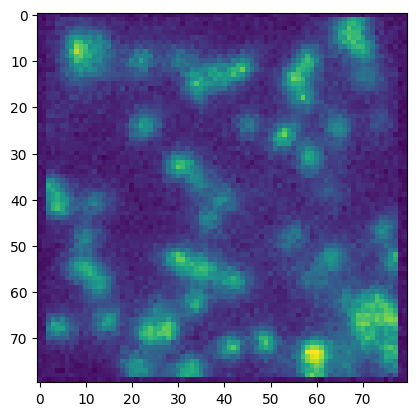

In [21]:
plt.imshow(observation['images'][0][0])

In [22]:
observation['images'][0][0].shape

torch.Size([80, 80])

In [23]:
est_cat['n_sources'][0][0].shape

torch.Size([18])

In [24]:
est_cat['redshifts'][0].shape

torch.Size([18, 18, 1])

In [25]:
observation['tile_catalog']['redshifts'][0].shape

torch.Size([20, 20, 1, 1])

In [27]:
est_cat['redshifts'].flatten()

tensor([1.2604, 1.2504, 1.2726,  ..., 1.1751, 1.2611, 1.2257],
       grad_fn=<UnsafeViewBackward0>)

In [28]:
est_cat['redshifts'].shape

torch.Size([32, 18, 18, 1])

In [29]:
observation['tile_catalog']['redshifts'][:,1:-1, 1:-1].reshape(32,18,18,1).shape

torch.Size([32, 18, 18, 1])

In [30]:
observe_redshift = observation['tile_catalog']['redshifts'][:,1:-1, 1:-1].reshape(32,18,18,1).flatten()

In [31]:
est_redshift = est_cat['redshifts'].flatten()

In [32]:
est_n = est_cat['n_sources'].flatten()

In [33]:
est_n.shape

torch.Size([10368])

In [34]:
est_redshift.shape

torch.Size([10368])

In [41]:
est_redshift = est_n * est_redshift

<Axes: ylabel='Count'>

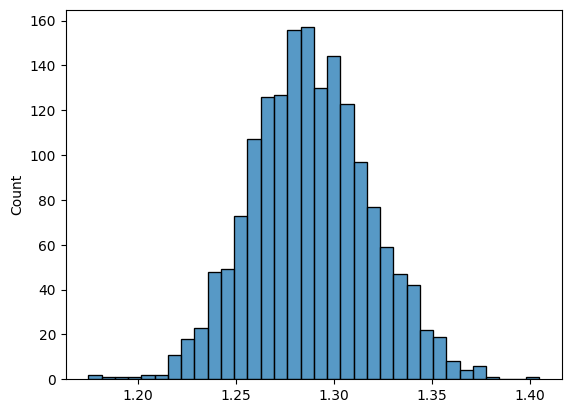

In [50]:
import seaborn as sns
sns.histplot(data = est_redshift.detach().numpy()[est_redshift.detach().numpy() > 0.1])

<Axes: ylabel='Count'>

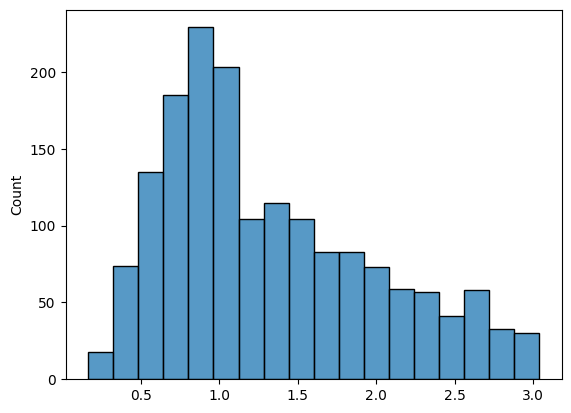

In [51]:
sns.histplot(data = observe_redshift.detach().numpy()[observe_redshift.detach().numpy() > 0.1])

In [45]:
mse = (np.square(est_redshift.detach().numpy() - observe_redshift.detach().numpy())).mean()
mse

0.07396156

In [38]:
import sys
sys.path.append('/home/songju/bliss/bliss/encoder')


In [39]:
from bliss.encoder.plotting import plot_detections
from bliss.catalog import TileCatalog

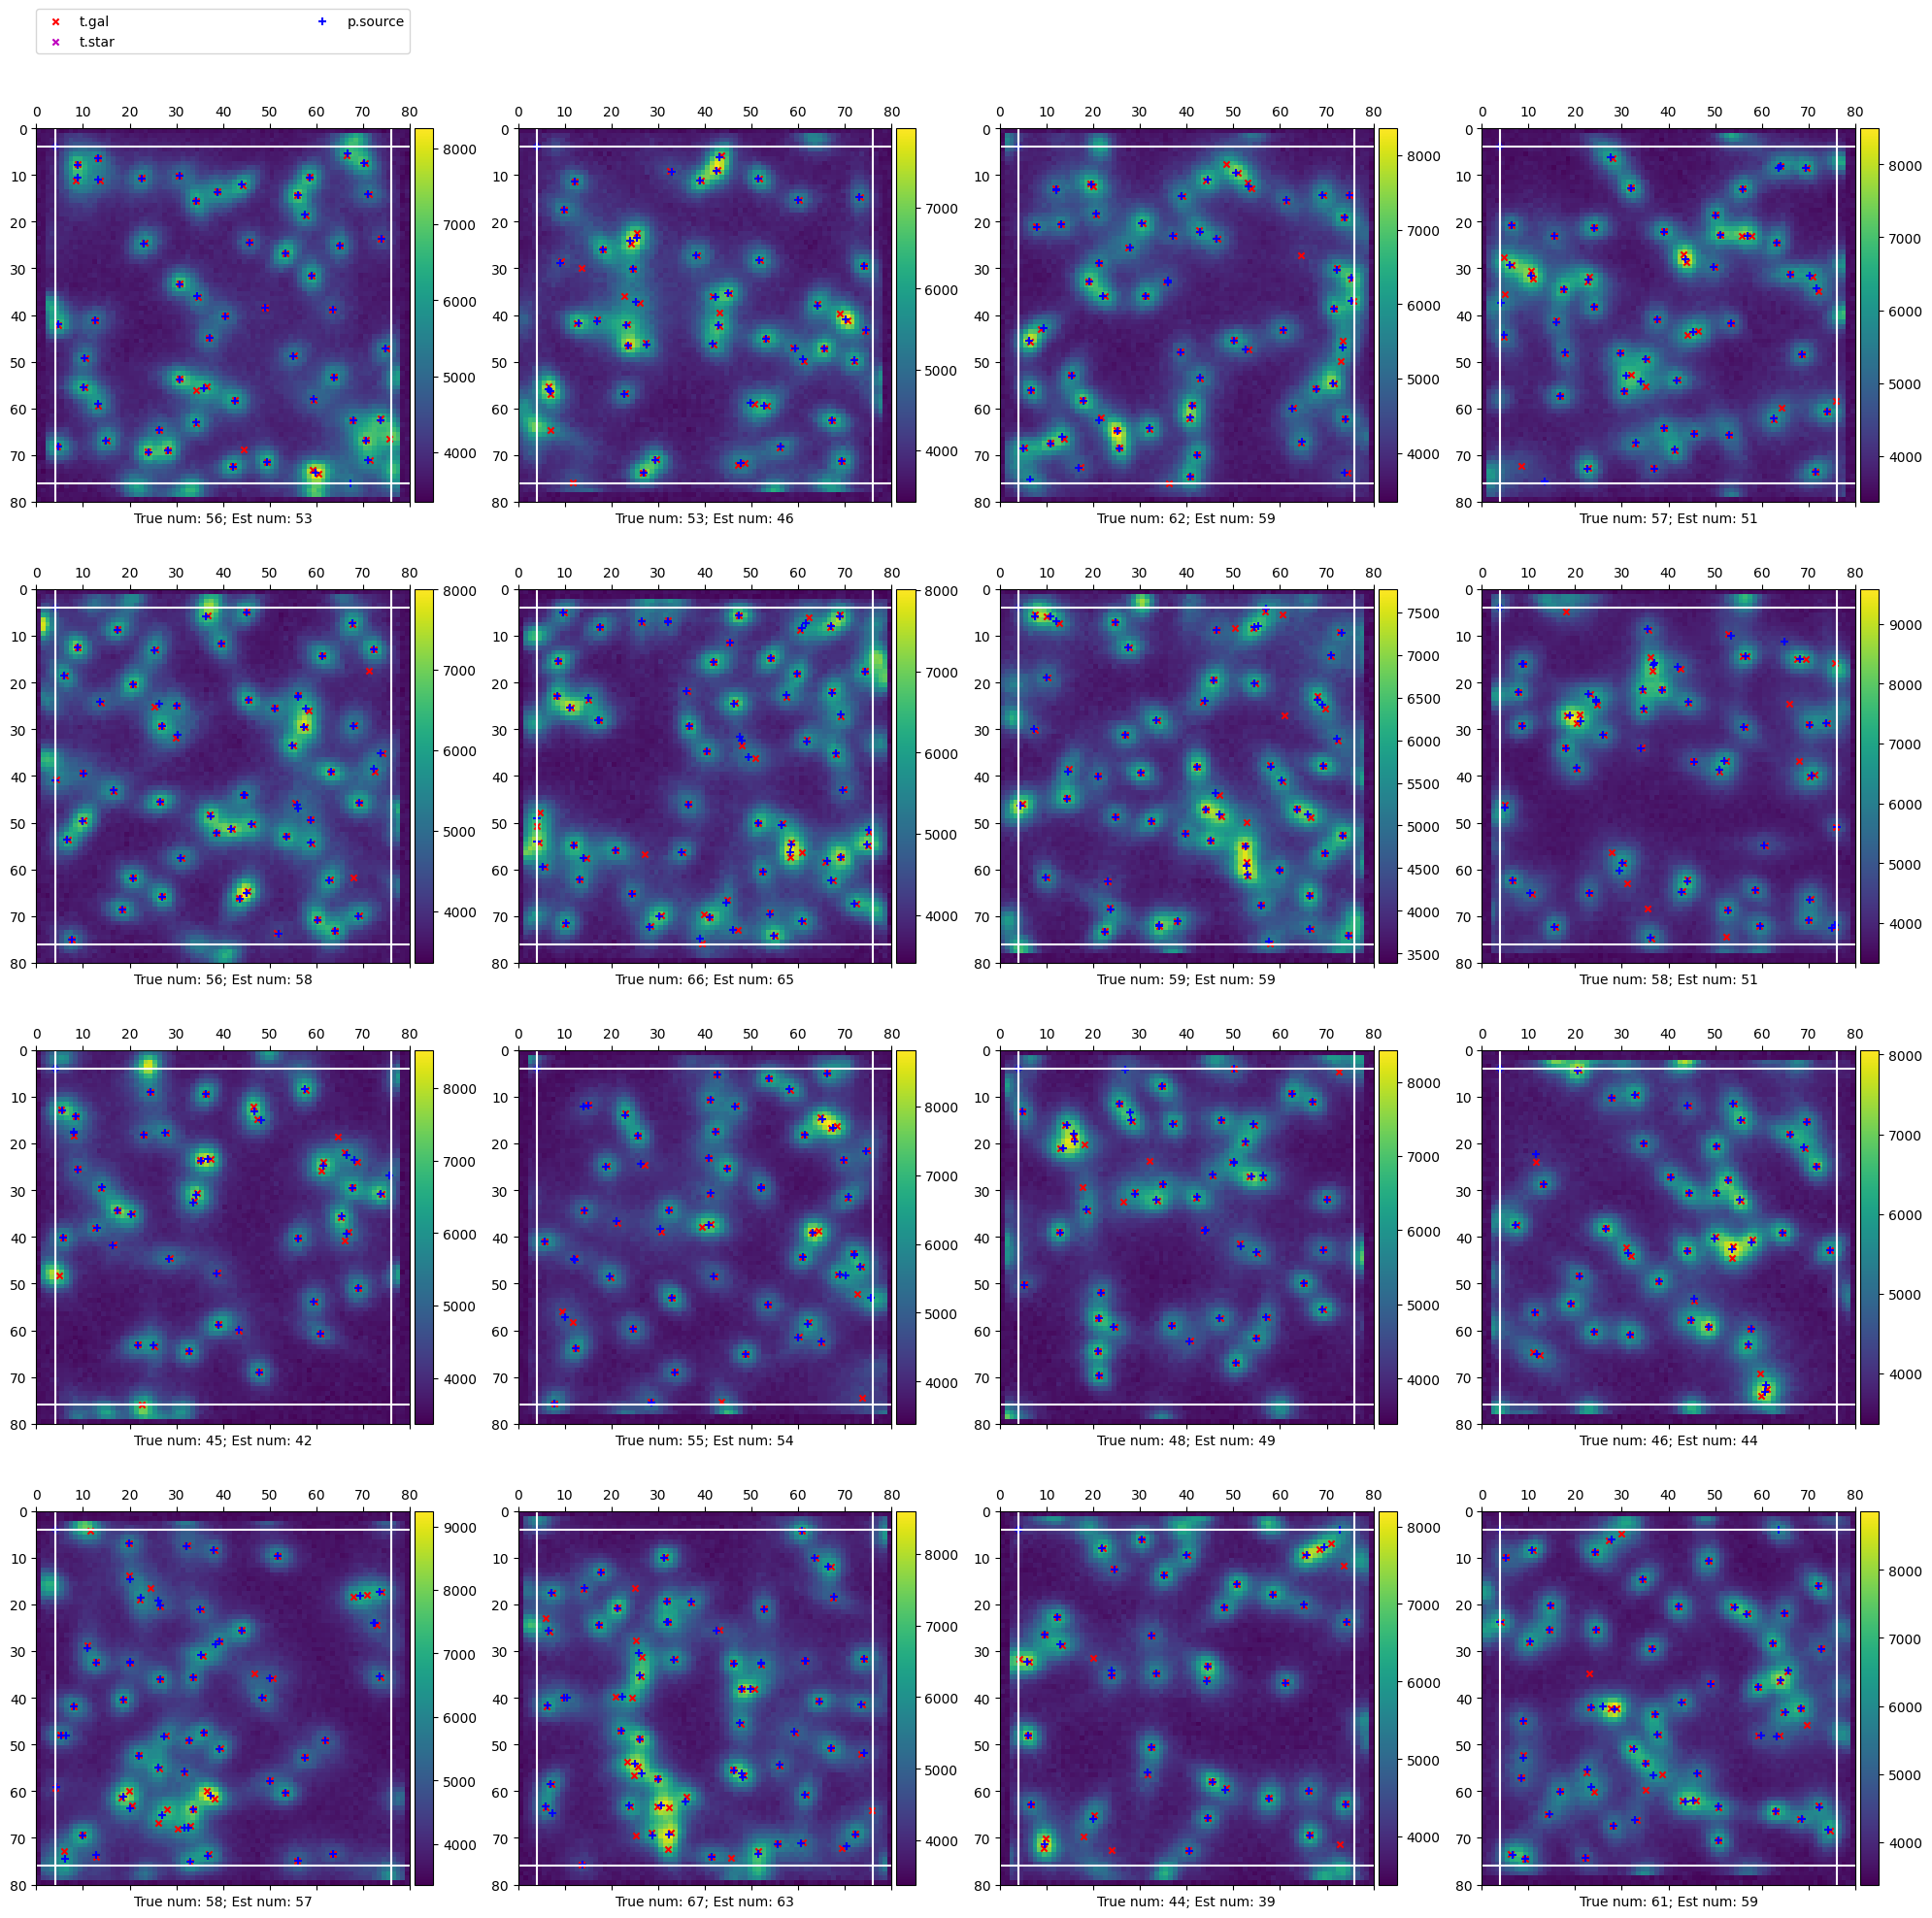

In [40]:
target_cat = TileCatalog(encoder.tile_slen, observation["tile_catalog"])
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
target_cat_cropped = target_cat.symmetric_crop(encoder.tiles_to_crop)
mp = encoder.tiles_to_crop * encoder.tile_slen
fig = plot_detections(observation["images"], target_cat_cropped, est_cat_ori, margin_px=mp)